<a href="https://colab.research.google.com/github/JimKing100/nfl-test/blob/master/neural-network/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from math import sqrt
from matplotlib import pyplot
import numpy

In [0]:
# Load data
defense_df = pd.read_csv('https://raw.githubusercontent.com/JimKing100/nfl-test/master/data-actuals/actuals_defense.csv')

In [105]:
defense_df.head()

,player,first,last,name,position1,2000-game1,2000-game2,2000-game3,2000-game4,2000-game5,2000-game6,2000-game7,2000-game8,2000-game9,2000-game10,2000-game11,2000-game12,2000-game13,2000-game14,2000-game15,2000-game16,2001-game1,2001-game2,2001-game3,2001-game4,2001-game5,2001-game6,2001-game7,2001-game8,2001-game9,2001-game10,2001-game11,2001-game12,2001-game13,2001-game14,2001-game15,2001-game16,2002-game1,2002-game2,2002-game3,...,2017-game9,2017-game10,2017-game11,2017-game12,2017-game13,2017-game14,2017-game15,2017-game16,2018-game1,2018-game2,2018-game3,2018-game4,2018-game5,2018-game6,2018-game7,2018-game8,2018-game9,2018-game10,2018-game11,2018-game12,2018-game13,2018-game14,2018-game15,2018-game16,2019-game1,2019-game2,2019-game3,2019-game4,2019-game5,2019-game6,2019-game7,2019-game8,2019-game9,2019-game10,2019-game11,2019-game12,2019-game13,2019-game14,2019-game15,2019-game16
0,SF,San Francisco,49ers,San Francisco 49ers,DF,-1.0,1.0,2.0,9.0,2.0,4.0,1.0,2.0,3.0,3.0,8.0,16.0,19.0,4.0,8.0,1.0,5.0,6.0,5.0,8.0,3.0,15.0,6.0,3.0,0.0,17.0,14.0,8.0,20.0,9.0,3.0,17.0,12,6,12,...,4,5,2,3,6,3,12,10,7.0,4.0,-1.0,8.0,0.0,2.0,-1.0,9.0,11.0,1.0,1.0,0.0,3.0,3.0,8.0,-5.0,24,7,6,14,9,9,16,3,19,14,10,3,-3,1,7,1
1,CHI,Chicago,Bears,Chicago Bears,DF,2.0,-1.0,9.0,7.0,8.0,9.0,4.0,8.0,12.0,3.0,19.0,3.0,0.0,3.0,8.0,15.0,5.0,10.0,26.0,14.0,8.0,14.0,11.0,5.0,10.0,9.0,10.0,5.0,13.0,11.0,26.0,15.0,7,11,6,...,3,5,4,5,10,6,11,8,14.0,17.0,13.0,13.0,5.0,2.0,4.0,27.0,12.0,14.0,13.0,4.0,17.0,8.0,6.0,7.0,8,5,21,14,4,-2,4,4,7,5,4,4,2,1,1,8
2,CIN,Cincinnati,Bengals,Cincinnati Bengals,DF,3.0,9.0,-1.0,5.0,12.0,2.0,8.0,8.0,1.0,2.0,4.0,3.0,8.0,1.0,4.0,11.0,5.0,23.0,1.0,7.0,5.0,2.0,10.0,2.0,5.0,9.0,9.0,13.0,1.0,8.0,20.0,7.0,0,1,0,...,6,10,5,3,1,3,7,9,12.0,12.0,0.0,0.0,22.0,-1.0,1.0,19.0,-5.0,4.0,-3.0,4.0,2.0,10.0,2.0,10.0,6,-1,5,2,1,9,2,0,-2,8,6,8,5,1,1,12
3,BUF,Buffalo,Bills,Buffalo Bills,DF,9.0,8.0,2.0,3.0,3.0,10.0,1.0,15.0,10.0,20.0,12.0,6.0,3.0,-1.0,4.0,13.0,2.0,10.0,2.0,-3.0,11.0,1.0,11.0,13.0,0.0,3.0,1.0,10.0,12.0,10.0,7.0,2.0,2,14,3,...,-3,-4,7,5,4,9,7,4,-1.0,1.0,14.0,6.0,11.0,15.0,-3.0,2.0,0.0,10.0,7.0,5.0,2.0,3.0,7.0,13.0,7,6,11,3,10,11,4,7,4,9,10,11,3,17,2,7
4,DEN,Denver,Broncos,Denver Broncos,DF,11.0,13.0,18.0,13.0,10.0,13.0,22.0,3.0,6.0,18.0,8.0,12.0,9.0,14.0,10.0,13.0,5.0,10.0,2.0,16.0,9.0,7.0,18.0,-1.0,12.0,10.0,6.0,2.0,12.0,11.0,10.0,2.0,8,7,12,...,-2,4,4,11,11,4,4,12,12.0,3.0,6.0,1.0,4.0,7.0,31.0,3.0,4.0,7.0,11.0,13.0,7.0,7.0,1.0,6.0,0,1,0,7,11,17,0,7,2,7,3,7,15,5,5,5


In [106]:
column_names = ['game', 'points']
series_df = pd.DataFrame(columns = column_names)

for i in range (1, 321):
    game = i
    col = i + 4
    points = defense_df.iloc[:, col].loc[(defense_df['player']=='CHI')].iloc[0]

    series_df = series_df.append({'game': game, 'points': points}, ignore_index=True)

series_df.tail()

,game,points
315,316.0,4.0
316,317.0,2.0
317,318.0,1.0
318,319.0,1.0
319,320.0,8.0


In [107]:
series = pd.Series(series_df['points'].values, index=series_df['game'])
series

game
1.0      2.0
2.0     -1.0
3.0      9.0
4.0      7.0
5.0      8.0
        ... 
316.0    4.0
317.0    2.0
318.0    1.0
319.0    1.0
320.0    8.0
Length: 320, dtype: float64

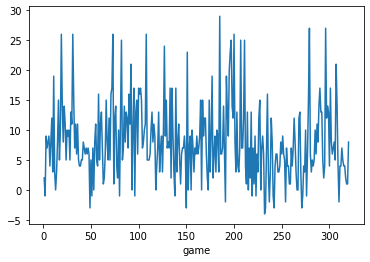

In [108]:
series.plot()
pyplot.show()

In [0]:
# Frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [0]:
# Scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [0]:
# Inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [0]:
# Fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
      print(i)
      model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
      model.reset_states()
    return model

In [0]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [0]:
# Transform data to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
supervised_values = supervised.values

In [0]:
# split data into train and test-sets
train, test = supervised_values[0:-16], supervised_values[-16:]

In [0]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [117]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([[-0.4805746 ],
       [-0.45562062],
       [-0.45575443],
       [-0.4102233 ],
       [-0.38542408],
       [-0.36140993],
       [-0.33448663],
       [-0.34836265],
       [-0.33443552],
       [-0.28477886],
       [-0.31595892],
       [-0.27246043],
       [-0.3035571 ],
       [-0.34781116],
       [-0.3646816 ],
       [-0.34728318],
       [-0.2795666 ],
       [-0.2974329 ],
       [-0.27635384],
       [-0.31340188],
       [-0.13903555],
       [-0.16036001],
       [-0.12115446],
       [-0.10850373],
       [-0.17415509],
       [-0.1807859 ],
       [-0.19137111],
       [-0.18851718],
       [-0.23173916],
       [-0.19216472],
       [-0.16511202],
       [-0.24499643],
       [-0.06314895],
       [-0.11705112],
       [-0.12539026],
       [-0.17934251],
       [-0.17157388],
       [-0.21881434],
       [-0.26159483],
       [-0.29424578],
       [-0.3133162 ],
       [-0.3275331 ],
       [-0.3179456 ],
       [-0.31672305],
       [-0.32329172],
       [-0

In [118]:
# walk-forward validation on the test data
predictions = list()
yhat_sum = 0
for i in range(len(test_scaled)):
  # make one-step forecast
  X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
  yhat = forecast_lstm(lstm_model, 1, X)
  # invert scaling
  yhat = invert_scale(scaler, X, yhat)
  # invert differencing
  #yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
  # store forecast
  predictions.append(yhat)
  raw_values = series.values
  expected = raw_values[len(train) + i]
  print('Game=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
  yhat_sum = yhat_sum + yhat
print(yhat_sum)

Game=1, Predicted=8.798941, Expected=8.000000
Game=2, Predicted=8.584490, Expected=5.000000
Game=3, Predicted=8.059652, Expected=21.000000
Game=4, Predicted=8.361130, Expected=14.000000
Game=5, Predicted=10.429769, Expected=4.000000
Game=6, Predicted=9.381374, Expected=-2.000000
Game=7, Predicted=8.059839, Expected=4.000000
Game=8, Predicted=7.541977, Expected=4.000000
Game=9, Predicted=7.157586, Expected=7.000000
Game=10, Predicted=7.173298, Expected=5.000000
Game=11, Predicted=6.985067, Expected=4.000000
Game=12, Predicted=6.743117, Expected=4.000000
Game=13, Predicted=6.563309, Expected=2.000000
Game=14, Predicted=6.256081, Expected=1.000000
Game=15, Predicted=5.951428, Expected=1.000000
Game=16, Predicted=5.744206, Expected=8.000000
121.79126361012459
